In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
plt.rcParams["figure.figsize"] = (20,7)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
sns.set_style("darkgrid")
import pickle
import warnings
warnings.filterwarnings("ignore")

In [135]:
Filepath = r'D:\Samarjit\Hackerearth\Tredence\Data\cc2dca92b57d11ec\dataset\train.csv'
train_df = pd.read_csv(Filepath,parse_dates=['date'])
train_df.head()

,ID,date,warehouse_ID,Latitude,Longitude,Product_Type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,weekly_dispatch_count
0,0x2710,2017-01-01,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,Yes,No,5.5,5.5
1,0x33e6,2017-01-01,WH_0x3ea,38.749077,-105.183060,Type_A,2017,January,Yes,No,6.1,6.1
2,0x2711,2017-01-02,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,No,No,4.8,NaN
3,0x33e7,2017-01-02,WH_0x3ea,38.749077,-105.183060,Type_A,2017,January,No,No,6.7,NaN
4,0x2712,2017-01-03,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,No,No,5.8,NaN


In [136]:
train_df.date.min(),train_df.date.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2021-04-30 00:00:00'))

In [137]:
train_df.shape

(16644, 12)

In [138]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16644 entries, 0 to 16643
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     16644 non-null  object        
 1   date                   16644 non-null  datetime64[ns]
 2   warehouse_ID           16644 non-null  object        
 3   Latitude               16312 non-null  float64       
 4   Longitude              16228 non-null  float64       
 5   Product_Type           16644 non-null  object        
 6   year                   16644 non-null  int64         
 7   month                  16644 non-null  object        
 8   is_weekend             16145 non-null  object        
 9   is_warehouse_closed    16478 non-null  object        
 10  daily_dispatch_count   16644 non-null  float64       
 11  weekly_dispatch_count  2372 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory

# Data Cleaning/Analysis/Preparation

### Feature Engineering

In [139]:
train_df['weekday']=train_df.date.dt.weekday

In [140]:
train_df['is_Sunday']=train_df['weekday'].apply(lambda x:'Yes' if x==6 else 'No')

In [141]:
train_df.is_weekend.fillna(train_df.date.dt.weekday,inplace=True)
train_df.is_weekend = train_df.is_weekend.apply(lambda x: 'Yes' if x not in ['Yes','No'] and x in ['5','6'] else ('No' if x not in ['Yes','No'] else x))

In [142]:
train_df.isnull().sum()

ID                           0
date                         0
warehouse_ID                 0
Latitude                   332
Longitude                  416
Product_Type                 0
year                         0
month                        0
is_weekend                   0
is_warehouse_closed        166
daily_dispatch_count         0
weekly_dispatch_count    14272
weekday                      0
is_Sunday                    0
dtype: int64

In [143]:
train_df[(train_df.is_Sunday == 'Yes') & (train_df.weekly_dispatch_count.isnull() == True)].shape

(0, 14)

In [144]:
train_df[(train_df.is_Sunday == 'No') & (train_df.weekly_dispatch_count.isnull() == False)].shape

(0, 14)

As per the problem statement all the weekly dispatch count measured on sundays.

### Analysis on is_warehouse_closed

In [145]:
train_df[(train_df.is_warehouse_closed == 'Yes') & (train_df.weekly_dispatch_count.isnull() == False)\
         & (train_df.daily_dispatch_count == float(0))].shape

(190, 14)

In [146]:
train_df[train_df['is_warehouse_closed'] == 'Yes'].daily_dispatch_count.value_counts()

0.0    1113
Name: daily_dispatch_count, dtype: int64

### Missing Impuation on is_warehouse_closed

In [147]:
print('{} % is probable for warehouse to be closed on weekend for weekly/daily dispatch.'.format(round(((train_df[(train_df.is_weekend == 'Yes') & \
                                         (train_df.is_warehouse_closed == 'Yes')].shape[0]/train_df.shape[0])*100),4)))
print('{} % is probable for warehouse to be opened on weekend for weekly/daily dispatch.'.format(round(((train_df[(train_df.is_weekend == 'Yes') & \
                                         (train_df.is_warehouse_closed == 'No')].shape[0]/train_df.shape[0])*100),4)))

2.3792 % is probable for warehouse to be closed on weekend for weekly/daily dispatch.
24.9459 % is probable for warehouse to be opened on weekend for weekly/daily dispatch.


In [148]:
print('{} % is probable for warehouse to be closed on weekdays for weekly/daily dispatch.'.format(round(((train_df[(train_df.is_weekend == 'No') & \
                                         (train_df.is_warehouse_closed == 'Yes')].shape[0]/train_df.shape[0])*100),4)))
print('{} % is probable for warehouse to be opened on weekdays for weekly/daily dispatch.'.format(round(((train_df[(train_df.is_weekend == 'No') & \
                                         (train_df.is_warehouse_closed == 'No')].shape[0]/train_df.shape[0])*100),4)))

4.3079 % is probable for warehouse to be closed on weekdays for weekly/daily dispatch.
67.3696 % is probable for warehouse to be opened on weekdays for weekly/daily dispatch.


In [149]:
train_df.is_warehouse_closed.fillna('No',inplace=True)

Imputing is_warehouse_closed as 'No'

In [150]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16644 entries, 0 to 16643
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     16644 non-null  object        
 1   date                   16644 non-null  datetime64[ns]
 2   warehouse_ID           16644 non-null  object        
 3   Latitude               16312 non-null  float64       
 4   Longitude              16228 non-null  float64       
 5   Product_Type           16644 non-null  object        
 6   year                   16644 non-null  int64         
 7   month                  16644 non-null  object        
 8   is_weekend             16644 non-null  object        
 9   is_warehouse_closed    16644 non-null  object        
 10  daily_dispatch_count   16644 non-null  float64       
 11  weekly_dispatch_count  2372 non-null   float64       
 12  weekday                16644 non-null  int64         
 13  i

### Missing Impuation on Latitude & Longitude

In [151]:
def imputemissing(df,group_df,driver,sel_cols):
  for cols in sel_cols:
    for index,row in df[df[cols].isnull() == True].iterrows():
      value = group_df[group_df[driver] == row[driver]][cols].values[0]
      df[cols].loc[index] = value

  return df

sel_cols = ['Latitude','Longitude']
group_lat_df = pd.DataFrame(train_df.groupby(by='warehouse_ID')[sel_cols[0]].max())
group_lat_df.reset_index(inplace=True)
group_long_df = pd.DataFrame(train_df.groupby(by='warehouse_ID')[sel_cols[1]].max())
group_long_df.reset_index(inplace=True)
group_df = pd.merge(group_lat_df,group_long_df,on = 'warehouse_ID',how = 'inner')
group_df

train_df = imputemissing(train_df,group_df,'warehouse_ID',sel_cols)
train_df[sel_cols].isnull().sum()

Latitude     0
Longitude    0
dtype: int64

In [152]:
train_df[train_df['warehouse_ID'].isin(train_df['warehouse_ID'].unique())]['Latitude'].unique()

array([41.681471, 38.749077, 35.67897 , 34.361664, 25.750156, 30.189375,
       41.611603, 48.692551, 37.915825, 61.600803])

In [153]:
train_df[train_df['warehouse_ID'].isin(train_df['warehouse_ID'].unique())]['Longitude'].unique()

array([ -72.794746, -105.18306 , -109.067413,  -86.305595,  -80.27964 ,
        -82.648254,  -87.551186, -116.319862,  -89.829262, -149.125259])

In [154]:
train_df.isnull().sum()

ID                           0
date                         0
warehouse_ID                 0
Latitude                     0
Longitude                    0
Product_Type                 0
year                         0
month                        0
is_weekend                   0
is_warehouse_closed          0
daily_dispatch_count         0
weekly_dispatch_count    14272
weekday                      0
is_Sunday                    0
dtype: int64

### Encoding Feature

In [155]:
def convertmonth(x):
  month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December']
  monthnum = range(1,13,1)
  monthdict = dict()
  for v1,v2 in zip(month,monthnum):
    monthdict[v1] = v2
  
  return monthdict[x]

In [156]:
def encodeWid(x):
  warehouse_list = ['WH_0x3e9', 'WH_0x3ea', 'WH_0x3eb', 'WH_0x3ec', 'WH_0x3ed',
       'WH_0x3ee', 'WH_0x3ef', 'WH_0x3f1', 'WH_0x3f0', 'WH_0x3f2']

  numbers = range(1,11,1)
  warehouse_dict = dict()
  for v1,v2 in zip(warehouse_list,numbers):
    warehouse_dict[v1] = v2
  
  return warehouse_dict[x]

In [43]:
train_df.Product_Type = train_df.Product_Type.apply(lambda x: 0 if x == 'Type_A' else 1)
train_df.is_weekend = train_df.is_weekend.apply(lambda x: 1 if x == 'Yes' else 0)
train_df.is_warehouse_closed = train_df.is_warehouse_closed.apply(lambda x: 1 if x == 'Yes' else 0)
#train_df.month = train_df.month.apply(lambda x: convertmonth(x))
train_df.warehouse_ID = train_df.warehouse_ID.apply(lambda x: encodeWid(x))

In [44]:
train_df.head()

,ID,date,warehouse_ID,Latitude,Longitude,Product_Type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,weekly_dispatch_count,weekday,is_Sunday
0,0x2710,2017-01-01,1,41.681471,-72.794746,0,2017,January,1,0,5.5,5.5,6,Yes
1,0x33e6,2017-01-01,2,38.749077,-105.183060,0,2017,January,1,0,6.1,6.1,6,Yes
2,0x2711,2017-01-02,1,41.681471,-72.794746,0,2017,January,0,0,4.8,NaN,0,No
3,0x33e7,2017-01-02,2,38.749077,-105.183060,0,2017,January,0,0,6.7,NaN,0,No
4,0x2712,2017-01-03,1,41.681471,-72.794746,0,2017,January,0,0,5.8,NaN,1,No


#### Transforming Latitude and Longitude to X-Y-Z co-ordinates.

In [45]:
def cordinate1(df):
  df['x-co'] = pd.Series([np.cos(lat) * np.cos(lon) for lat,lon in df[['Latitude','Longitude']].values])
  df['y-co'] = pd.Series([np.cos(lat) * np.sin(lon) for lat,lon in df[['Latitude','Longitude']].values])
  df['z-co'] = pd.Series([np.sin(lat) for lat in df['Latitude'].values])
  return df

In [46]:
train_df = cordinate1(train_df)

In [47]:
train_df.drop(columns = ['Latitude','Longitude'],inplace=True)

In [48]:
train_df.head()

,ID,date,warehouse_ID,Product_Type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,weekly_dispatch_count,weekday,is_Sunday,x-co,y-co,z-co
0,0x2710,2017-01-01,1,0,2017,January,1,0,5.5,5.5,6,Yes,0.572644,-0.341794,-0.745155
1,0x33e6,2017-01-01,2,0,2017,January,1,0,6.1,6.1,6,Yes,-0.029984,0.496697,0.867406
2,0x2711,2017-01-02,1,0,2017,January,0,0,4.8,NaN,0,No,0.572644,-0.341794,-0.745155
3,0x33e7,2017-01-02,2,0,2017,January,0,0,6.7,NaN,0,No,-0.029984,0.496697,0.867406
4,0x2712,2017-01-03,1,0,2017,January,0,0,5.8,NaN,1,No,0.572644,-0.341794,-0.745155


In [49]:
train_df.drop(columns = 'ID',inplace=True)

In [50]:
train_df.shape

(16644, 14)

In [51]:
train_df_copy = train_df.copy()

### Replacing NAN values of weekly dispatch with the corressponding week's weekly dispatch count measured on Sunday.

In [52]:
for id in train_df_copy.warehouse_ID.unique():
    
    df = train_df_copy[(train_df_copy.warehouse_ID  == id) & (train_df_copy.Product_Type == 0) & (train_df_copy.is_Sunday == 'Yes')]
    indexlist = df.index
    product_a_weekly_dispatch_count = df.weekly_dispatch_count.values.tolist()
    index = list()
    for idx in range(len(indexlist)-1):
        index_list = train_df_copy[(train_df_copy.warehouse_ID  == id) & (train_df_copy.Product_Type == 0) & \
                (train_df_copy.date > train_df_copy['date'].iloc[indexlist[idx]]) \
                                  & (train_df_copy.date < train_df_copy['date'].iloc[indexlist[idx + 1]])].index
        
        train_df_copy['weekly_dispatch_count'].iloc[index_list] = product_a_weekly_dispatch_count[idx]
        if idx == len(indexlist)-2:
            index_list = train_df_copy[(train_df_copy.warehouse_ID  == id) & (train_df_copy.Product_Type == 0) & \
                (train_df_copy.date > train_df_copy['date'].iloc[indexlist[idx + 1]])].index
            train_df_copy['weekly_dispatch_count'].iloc[index_list] = product_a_weekly_dispatch_count[idx + 1]
        
    df = train_df_copy[(train_df_copy.warehouse_ID  == id) & (train_df_copy.Product_Type == 1) & (train_df_copy.is_Sunday == 'Yes')]
    indexlist = df.index
    product_b_weekly_dispatch_count = df.weekly_dispatch_count.values.tolist()
    for idx in range(len(indexlist)-1):
        df = train_df_copy[(train_df_copy.warehouse_ID  == id) & (train_df_copy.Product_Type == 1) & (train_df_copy.is_Sunday == 'Yes')]
        indexlist = df.index
        product_b_weekly_dispatch_count = df.weekly_dispatch_count.values.tolist()
        index_list = train_df_copy[(train_df_copy.warehouse_ID  == id) & (train_df_copy.Product_Type == 1) & \
                (train_df_copy.date > train_df_copy['date'].iloc[indexlist[idx]]) \
                                  & (train_df_copy.date < train_df_copy['date'].iloc[indexlist[idx + 1]])].index
        train_df_copy['weekly_dispatch_count'].iloc[index_list] = product_b_weekly_dispatch_count[idx]
        if idx == len(indexlist)-2:
            index_list = train_df_copy[(train_df_copy.warehouse_ID  == id) & (train_df_copy.Product_Type == 1) & \
                (train_df_copy.date > train_df_copy['date'].iloc[indexlist[idx + 1]])].index
            train_df_copy['weekly_dispatch_count'].iloc[index_list] = product_b_weekly_dispatch_count[idx + 1]
            

In [53]:
train_df_copy.head()

,date,warehouse_ID,Product_Type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,weekly_dispatch_count,weekday,is_Sunday,x-co,y-co,z-co
0,2017-01-01,1,0,2017,January,1,0,5.5,5.5,6,Yes,0.572644,-0.341794,-0.745155
1,2017-01-01,2,0,2017,January,1,0,6.1,6.1,6,Yes,-0.029984,0.496697,0.867406
2,2017-01-02,1,0,2017,January,0,0,4.8,5.5,0,No,0.572644,-0.341794,-0.745155
3,2017-01-02,2,0,2017,January,0,0,6.7,6.1,0,No,-0.029984,0.496697,0.867406
4,2017-01-03,1,0,2017,January,0,0,5.8,5.5,1,No,0.572644,-0.341794,-0.745155


In [54]:
train_df_copy.tail()

,date,warehouse_ID,Product_Type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,weekly_dispatch_count,weekday,is_Sunday,x-co,y-co,z-co
16639,2021-04-30,9,1,2021,April,0,0,0.2,16.8,4,No,-0.282884,-0.934742,0.215021
16640,2021-04-30,8,0,2021,April,0,0,12.3,43.5,4,No,0.002128,-0.000173,-0.999998
16641,2021-04-30,8,1,2021,April,0,0,3.3,12.3,4,No,0.002128,-0.000173,-0.999998
16642,2021-04-30,10,0,2021,April,0,0,7.1,55.9,4,No,-0.033399,0.331570,-0.942839
16643,2021-04-30,10,1,2021,April,0,0,3.4,8.2,4,No,-0.033399,0.331570,-0.942839


In [55]:
train_df_copy.shape

(16644, 14)

Droping rows where weekly_dispatch_count is null beacuse of its corressponding week's Sunday, there was no Weekly dispatch count for a specific Warehouse

In [56]:
train_df_copy[train_df_copy.weekly_dispatch_count.isnull() == True].shape

(60, 14)

In [57]:
train_df_copy=train_df_copy[train_df_copy.weekly_dispatch_count.isnull() == False]

In [58]:
train_df_copy[train_df_copy.weekly_dispatch_count.isnull() == True].shape

(0, 14)

In [59]:
train_df_copy.shape

(16584, 14)

In [60]:
train_df_copy.reset_index(drop='index',inplace=True)

In [61]:
train_df_copy['day'] = train_df_copy.date.dt.day
train_df_copy.is_Sunday = train_df_copy.is_Sunday.apply(lambda x: 1 if x == 'Yes' else 0)

In [62]:
train_df_copy.head()

,date,warehouse_ID,Product_Type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,weekly_dispatch_count,weekday,is_Sunday,x-co,y-co,z-co,day
0,2017-01-01,1,0,2017,January,1,0,5.5,5.5,6,1,0.572644,-0.341794,-0.745155,1
1,2017-01-01,2,0,2017,January,1,0,6.1,6.1,6,1,-0.029984,0.496697,0.867406,1
2,2017-01-02,1,0,2017,January,0,0,4.8,5.5,0,0,0.572644,-0.341794,-0.745155,2
3,2017-01-02,2,0,2017,January,0,0,6.7,6.1,0,0,-0.029984,0.496697,0.867406,2
4,2017-01-03,1,0,2017,January,0,0,5.8,5.5,1,0,0.572644,-0.341794,-0.745155,3


Removing the rows with daily_dispatch_count as 0 as the Warehouse is closed on those days and no dispatch made from the corressponding warehouse.

In [63]:
train_df_copy[train_df_copy.daily_dispatch_count==0.0].is_warehouse_closed.value_counts()

1    1113
0      14
Name: is_warehouse_closed, dtype: int64

In [64]:
train_df_copy.shape

(16584, 15)

In [65]:
train_df_copy_n = train_df_copy[train_df_copy.is_warehouse_closed==0]
train_df_copy_n.reset_index(drop='index',inplace=True)

In [66]:
train_df_copy_n.shape

(15471, 15)

In [67]:
train_df_copy_n = pd.get_dummies(train_df_copy_n, \
                columns=['warehouse_ID', 'is_weekend','weekday','day'])
train_df_copy_n.head()

,date,Product_Type,year,month,is_warehouse_closed,daily_dispatch_count,weekly_dispatch_count,is_Sunday,x-co,y-co,z-co,warehouse_ID_1,warehouse_ID_2,warehouse_ID_3,warehouse_ID_4,warehouse_ID_5,warehouse_ID_6,warehouse_ID_7,warehouse_ID_8,warehouse_ID_9,warehouse_ID_10,is_weekend_0,is_weekend_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,2017-01-01,0,2017,January,0,5.5,5.5,1,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-01,0,2017,January,0,6.1,6.1,1,-0.029984,0.496697,0.867406,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-02,0,2017,January,0,4.8,5.5,0,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-02,0,2017,January,0,6.7,6.1,0,-0.029984,0.496697,0.867406,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-03,0,2017,January,0,5.8,5.5,0,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
train_df_copy_n.shape

(15471, 61)

Removing the rows with weekly/daily dispatch count as 0 because of the Performance Metric.

In [69]:
indexlist = train_df_copy_n[train_df_copy_n.weekly_dispatch_count == float(0)].index
train_df_copy_n.drop(index = indexlist, inplace=True)
train_df_copy_n.reset_index(drop = 'index',inplace=True)

In [70]:
train_df_copy_n.shape

(15469, 61)

In [71]:
train_df_copy_n.head()

,date,Product_Type,year,month,is_warehouse_closed,daily_dispatch_count,weekly_dispatch_count,is_Sunday,x-co,y-co,z-co,warehouse_ID_1,warehouse_ID_2,warehouse_ID_3,warehouse_ID_4,warehouse_ID_5,warehouse_ID_6,warehouse_ID_7,warehouse_ID_8,warehouse_ID_9,warehouse_ID_10,is_weekend_0,is_weekend_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,2017-01-01,0,2017,January,0,5.5,5.5,1,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-01-01,0,2017,January,0,6.1,6.1,1,-0.029984,0.496697,0.867406,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-01-02,0,2017,January,0,4.8,5.5,0,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017-01-02,0,2017,January,0,6.7,6.1,0,-0.029984,0.496697,0.867406,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017-01-03,0,2017,January,0,5.8,5.5,0,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
train_df_copy_n=train_df_copy_n.drop('date',axis=1)

In [73]:
train_df_copy_n[train_df_copy_n.daily_dispatch_count == float(0)].shape

(14, 60)

In [74]:
train_df_copy_n.head()

,Product_Type,year,month,is_warehouse_closed,daily_dispatch_count,weekly_dispatch_count,is_Sunday,x-co,y-co,z-co,warehouse_ID_1,warehouse_ID_2,warehouse_ID_3,warehouse_ID_4,warehouse_ID_5,warehouse_ID_6,warehouse_ID_7,warehouse_ID_8,warehouse_ID_9,warehouse_ID_10,is_weekend_0,is_weekend_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,0,2017,January,0,5.5,5.5,1,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2017,January,0,6.1,6.1,1,-0.029984,0.496697,0.867406,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2017,January,0,4.8,5.5,0,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2017,January,0,6.7,6.1,0,-0.029984,0.496697,0.867406,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,2017,January,0,5.8,5.5,0,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
train_df_copy_n[(train_df_copy_n.daily_dispatch_count==0.0)].shape

(14, 60)

In [76]:
indexlist = train_df_copy_n[(train_df_copy_n.daily_dispatch_count==0.0)].index
train_df_copy_n.drop(index=indexlist,inplace=True)
train_df_copy_n.reset_index(drop = 'index',inplace=True)

In [77]:
train_df_copy_n['year'] = train_df_copy_n['year'].apply(lambda x: str(x))
#train_df_copy_n['month'] = train_df_copy_n['month'].apply(lambda x: str(x))

In [78]:
train_df_copy_n.shape

(15455, 60)

# Train-Test Split

In [79]:
from sklearn.model_selection import train_test_split 

In [80]:
train,test = train_test_split(train_df_copy_n,train_size=0.8, test_size = 0.2, random_state=100)

In [81]:
train.shape,test.shape

((12364, 60), (3091, 60))

In [82]:
train,val = train_test_split(train,train_size=0.8, test_size = 0.2, random_state=100)

In [83]:
train.shape,val.shape

((9891, 60), (2473, 60))

In [84]:
y_daily_dispatch_count_train=train['daily_dispatch_count']
y_weekly_dispatch_count_train=train['weekly_dispatch_count']

X_train=train.drop(['daily_dispatch_count','weekly_dispatch_count'],axis=1)


In [85]:
y_daily_dispatch_count_test=test['daily_dispatch_count']
y_weekly_dispatch_count_test=test['weekly_dispatch_count']

X_test=test.drop(['daily_dispatch_count','weekly_dispatch_count'],axis=1)

In [86]:
y_daily_dispatch_count_val=val['daily_dispatch_count']
y_weekly_dispatch_count_val=val['weekly_dispatch_count']

X_val=val.drop(['daily_dispatch_count','weekly_dispatch_count'],axis=1)

In [87]:
X_train.shape,y_daily_dispatch_count_train.shape,y_weekly_dispatch_count_train.shape

((9891, 58), (9891,), (9891,))

In [88]:
X_test.shape,y_daily_dispatch_count_test.shape,y_weekly_dispatch_count_test.shape

((3091, 58), (3091,), (3091,))

In [89]:
X_val.shape,y_daily_dispatch_count_val.shape,y_weekly_dispatch_count_val.shape

((2473, 58), (2473,), (2473,))

### Encoding Year & Month

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
CountVectorizer1 = CountVectorizer()
X_train_year_bow = CountVectorizer1.fit_transform(X_train.year.values)
X_test_year_bow = CountVectorizer1.transform(X_test.year.values)
X_val_year_bow = CountVectorizer1.transform(X_val.year.values)

CountVectorizer2 = CountVectorizer()
X_train_month_bow = CountVectorizer2.fit_transform(X_train.month.values)
X_test_month_bow = CountVectorizer2.transform(X_test.month.values)
X_val_month_bow = CountVectorizer2.transform(X_val.month.values)

print(X_train_year_bow.shape,X_test_year_bow.shape,X_val_year_bow.shape)
print(X_train_month_bow.shape,X_test_month_bow.shape,X_val_month_bow.shape)

(9891, 5) (3091, 5) (2473, 5)
(9891, 12) (3091, 12) (2473, 12)


In [91]:
sel_cols = [col for col in X_train.columns if col not in ['year', 'month']]

X_train = hstack((X_train[sel_cols],X_train_year_bow,X_train_month_bow)).tocsr()
X_test = hstack((X_test[sel_cols],X_test_year_bow,X_test_month_bow)).tocsr()
X_val = hstack((X_val[sel_cols],X_val_year_bow,X_val_month_bow)).tocsr()

print(X_train.shape,X_test.shape,X_val.shape)

(9891, 73) (3091, 73) (2473, 73)


# Model Training

In [4]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from imblearn.metrics import sensitivity_specificity_support
#from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from prettytable import PrettyTable
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential,layers,Input,optimizers,callbacks,losses,models
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as k
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session

# Model 1(Predict Weekly Dispatch Count)

### Linear Regression

In [238]:
linear = LinearRegression()

linear.fit(X_train, y_weekly_dispatch_count_train)
print("Intercept: ", linear.intercept_)
print('------------------------------------------------------------------------------------------')
print("Coefficients:\n",linear.coef_)

Intercept:  49.61005019689745
------------------------------------------------------------------------------------------
Coefficients:
 [-2.95197546e+01  0.00000000e+00  1.23437006e-01  1.36986731e+00
 -2.91988448e-01  2.37265390e+00 -2.67244451e+00  7.29845499e+00
  5.97872294e+00  7.13677224e-01 -9.35988399e+00 -5.83485123e+00
 -7.89444572e+00  2.92236369e+00  4.30739621e+00  4.54101039e+00
  1.77444534e-01 -1.77444534e-01 -3.50905476e-01 -1.77846253e-01
 -1.25719113e-01 -3.67889459e-02  1.85739063e-01  3.82083718e-01
  1.23437006e-01  4.03261287e-01  6.36994258e-01  2.45242308e-01
  3.44411956e-03  7.06025722e-01 -1.75232393e-01  3.50060617e-01
 -1.45154376e-01 -4.73375176e-01 -1.28643162e-01 -2.64616097e-01
  1.33396699e-01 -1.60709670e-01  2.28540464e-02 -1.21316079e-01
  2.98816002e-04  1.84144664e-01 -2.01338334e-01 -5.65368882e-03
 -5.91275168e-01 -2.17211168e-01 -5.85393882e-01 -5.73059210e-01
 -2.36177243e-01  1.49938483e-01  4.45726594e-01  3.52830337e-01
  2.37140243e-02  3

In [239]:
def datadisplay(df):
  x= PrettyTable()
  x.field_names = df.columns
  for index, row in df.iterrows():
    x.add_row(row)
  return x

In [240]:
##Making predictions for train and test sets: linear Regression Model
y_weekly_dispatch_count_train_pred = linear.predict(X_train)
y_weekly_dispatch_count_val_pred= linear.predict(X_val)

'''y_pred_train = np.expm1(y_pred_train)
y_pred_test = np.expm1(y_pred_test)

Y_train = np.expm1(Y_train)
Y_val = np.expm1(Y_val)'''

##R2 score for linear Regression Model
r2_score_train = r2_score(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
r2_score_test = r2_score(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.8645    |    0.8566   |
|   MSE    |   57.5134    |   59.9368   |
|   MAPE   |    71.259    |    69.16    |
|   MAE    |    5.9543    |    5.9668   |
|   RMSE   |    7.5838    |    7.7419   |
+----------+--------------+-------------+


# LGBM

In [241]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

n_HP_points_to_test = 100
clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='r2',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True,
    n_jobs = -1)

gs.fit(X_train, y_weekly_dispatch_count_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(metric='None', n_estimators=5000,
                                           n_jobs=4, random_state=314,
                                           silent=True),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000255A55A7400>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002559A639CD0>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000255A55BDD90>,
                      

In [242]:
cv_results = pd.DataFrame(gs.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_min_child_samples,param_min_child_weight,param_num_leaves,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,11.583455,1.273428,1.879088,4.037319e-01,0.950124,301,0.1,28,0,100,0.932647,"{'colsample_bytree': 0.9501241488957805, 'min_...",0.954766,0.956502,0.950229,0.953832,0.002645,16
1,7.151564,1.414806,0.500113,2.366701e-01,0.973167,171,0.00001,41,10,100,0.557573,"{'colsample_bytree': 0.9731668400523877, 'min_...",0.954107,0.959138,0.952642,0.955296,0.002782,13
2,1.847013,0.062145,0.001334,4.718214e-04,0.775604,424,10000.0,30,0,100,0.934866,"{'colsample_bytree': 0.7756038066515227, 'min_...",-0.000421,-0.000018,-0.000264,-0.000235,0.000166,91
3,5.707445,0.370082,1.010589,5.697740e-02,0.819604,422,1000.0,28,2,5,0.664986,"{'colsample_bytree': 0.8196039247657971, 'min_...",0.828284,0.846533,0.826982,0.833933,0.008925,84
4,2.104468,0.079419,0.024341,4.784900e-03,0.806323,491,0.1,24,100,20,0.656442,"{'colsample_bytree': 0.8063232376017694, 'min_...",0.912373,0.911599,0.899630,0.907867,0.005833,80
5,9.694883,1.607000,1.687044,2.804154e-01,0.687909,163,10.0,10,1,0.1,0.677506,"{'colsample_bytree': 0.6879091728281055, 'min_...",0.959874,0.961716,0.953777,0.958456,0.003393,3
6,15.958778,7.756079,1.722897,3.225700e-01,0.875437,372,10.0,44,1,0,0.568664,"{'colsample_bytree': 0.8754369812451743, 'min_...",0.953383,0.954987,0.947714,0.952028,0.003120,28
7,9.261922,1.197963,1.552426,3.207862e-01,0.404829,350,0.001,36,1,5,0.927402,"{'colsample_bytree': 0.404828563763895, 'min_c...",0.945123,0.948264,0.941207,0.944865,0.002887,50
8,15.482399,1.707102,1.743700,1.494428e-01,0.727199,212,0.01,13,0.1,5,0.447821,"{'colsample_bytree': 0.7271985991098294, 'min_...",0.955421,0.956354,0.949030,0.953602,0.003255,17
9,11.502148,0.828201,1.387980,1.113326e-01,0.556075,103,10.0,22,2,1,0.893911,"{'colsample_bytree': 0.55607546409401, 'min_ch...",0.959344,0.961462,0.953252,0.958019,0.003480,5


In [243]:
gs.best_params_

{'colsample_bytree': 0.8885216205885169,
 'min_child_samples': 157,
 'min_child_weight': 0.1,
 'num_leaves': 17,
 'reg_alpha': 0,
 'reg_lambda': 50,
 'subsample': 0.3357756717412073}

In [244]:
clf_final = lgb.LGBMRegressor(**clf.get_params())
clf_final.fit(X_train, y_weekly_dispatch_count_train)

LGBMRegressor(metric='None', n_estimators=5000, n_jobs=4, random_state=314,
              silent=True)

In [245]:
##Making predictions for train and test sets: LGBM Model
y_weekly_dispatch_count_train_pred = clf_final.predict(X_train)
y_weekly_dispatch_count_val_pred= clf_final.predict(X_val)

##R2 score for linear Regression Model
r2_score_train = r2_score(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
r2_score_test = r2_score(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.9938    |    0.9497   |
|   MSE    |    2.6519    |   21.0141   |
|   MAPE   |   94.7493    |   85.3359   |
|   MAE    |    1.1856    |    2.971    |
|   RMSE   |    1.6285    |    4.5841   |
+----------+--------------+-------------+


# Deep Learning - ANN

In [246]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64,activation = 'relu', kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(32,activation = 'relu', kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4736      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,849
Trainable params: 6,849
Non-trainable params: 0
_________________________________________________________________


In [247]:
opt = optimizers.Adam(learning_rate=0.01)
mape = losses.MeanAbsolutePercentageError(
    reduction="auto",
    name="mean_absolute_percentage_error",
)
model.compile(loss = mape, optimizer=opt)
#early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#model_history = model.fit(X_train, y_weekly_dispatch_count_train,validation_split = 0.2, epochs = 50, batch_size = 1000, callbacks = [early_stopping_callback])
model_history = model.fit(X_train.toarray(), y_weekly_dispatch_count_train,validation_split = 0.2, epochs = 50, batch_size = 100)

Epoch 1/50
80/80 [==============================] - 1s 7ms/step - loss: 49.9076 - val_loss: 24.5662
Epoch 2/50
80/80 [==============================] - 0s 4ms/step - loss: 27.0790 - val_loss: 21.9138
Epoch 3/50
80/80 [==============================] - 0s 4ms/step - loss: 24.8778 - val_loss: 19.2782
Epoch 4/50
80/80 [==============================] - 0s 3ms/step - loss: 24.4935 - val_loss: 18.7331
Epoch 5/50
80/80 [==============================] - 0s 3ms/step - loss: 23.2924 - val_loss: 18.3430
Epoch 6/50
80/80 [==============================] - 0s 3ms/step - loss: 22.8235 - val_loss: 16.5732
Epoch 7/50
80/80 [==============================] - 0s 3ms/step - loss: 22.4756 - val_loss: 16.8563
Epoch 8/50
80/80 [==============================] - 0s 3ms/step - loss: 21.7678 - val_loss: 18.1827
Epoch 9/50
80/80 [==============================] - 0s 3ms/step - loss: 21.9062 - val_loss: 16.7835
Epoch 10/50
80/80 [==============================] - 0s 3ms/step - loss: 21.2173 - val_loss: 17.7835

In [248]:
##Making predictions for train and test sets: DNN Model
y_weekly_dispatch_count_train_pred = model.predict(X_train)
y_weekly_dispatch_count_val_pred= model.predict(X_val)

##R2 score for linear Regression Model
r2_score_train = r2_score(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
r2_score_test = r2_score(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.9582    |    0.9455   |
|   MSE    |   17.7423    |   22.7815   |
|   MAPE   |   88.6374    |   85.4952   |
|   MAE    |    2.9286    |    3.2646   |
|   RMSE   |    4.2122    |    4.773    |
+----------+--------------+-------------+


In [249]:
model.save('D:\\Samarjit\\Hackerearth\\Tredence\\model_1.h5')

Best Model has been choosen as DNN for Model 1(Predicted - Weekly dispatch count)

## Model 2(Predict Daily Dispatch Count)

# Linear Regression

In [250]:
linear = LinearRegression()

linear.fit(X_train, y_daily_dispatch_count_train)
print("Intercept: ", linear.intercept_)
print('------------------------------------------------------------------------------------------')
print("Coefficients:\n",linear.coef_)

Intercept:  7.302892115604971
------------------------------------------------------------------------------------------
Coefficients:
 [-4.20844080e+00  0.00000000e+00 -1.67133907e-01  1.21336902e-01
 -7.05181573e-02  3.15974746e-01 -3.97159924e-01  1.00385379e+00
  8.32883350e-01  5.82235782e-02 -1.28918537e+00 -7.98309936e-01
 -1.01476053e+00  4.70482357e-01  6.18035045e-01  5.15937649e-01
  4.31709509e-02 -4.31709509e-02 -4.40573203e-01 -1.41684820e-01
  2.45441497e-01  5.75009345e-01  8.55412932e-01 -9.26471843e-01
 -1.67133907e-01  3.79522968e-01  2.51684946e-01 -1.55137594e-02
 -5.65685095e-03 -1.64972385e-02 -4.68755359e-02 -4.61292188e-02
 -6.12165866e-02  1.78207235e-02  3.56990226e-02 -1.35708139e-01
  1.40863885e-03  2.87383358e-02 -8.01911083e-02 -2.32013655e-03
  3.57664293e-02  1.23504898e-02 -1.51368788e-01 -1.68258104e-02
 -1.38081363e-01  2.99344127e-02 -3.04371705e-02 -7.02070943e-02
  8.95114633e-02 -3.26439966e-02  1.35888874e-01 -3.19327005e-02
 -1.26533085e-01  3

In [251]:
##Making predictions for train and test sets: linear Regression Model
y_daily_dispatch_count_train_pred = linear.predict(X_train)
y_daily_dispatch_count_val_pred= linear.predict(X_val)

##R2 score for linear Regression Model
r2_score_train = r2_score(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
r2_score_test = r2_score(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.7478    |    0.7494   |
|   MSE    |    2.4924    |    2.4093   |
|   MAPE   |   41.1532    |   48.1496   |
|   MAE    |    1.2071    |    1.1968   |
|   RMSE   |    1.5787    |    1.5522   |
+----------+--------------+-------------+


# RandomForestRegressor

In [536]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_daily_dispatch_count_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [537]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

In [538]:
clf_final = RandomForestRegressor(**rf.get_params())
clf_final.fit(X_train, y_daily_dispatch_count_train)

RandomForestRegressor()

In [539]:
##Making predictions for train and test sets: RF Model
y_daily_dispatch_count_train_pred = clf_final.predict(X_train)
y_daily_dispatch_count_val_pred= clf_final.predict(X_val)

##R2 score for linear Regression Model
r2_score_train = r2_score(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
r2_score_test = r2_score(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.9485    |    0.7384   |
|   MSE    |    0.5092    |    2.5147   |
|   MAPE   |   76.1029    |    49.983   |
|   MAE    |    0.5117    |    1.1676   |
|   RMSE   |    0.7136    |    1.5858   |
+----------+--------------+-------------+


# LGBM

In [252]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

n_HP_points_to_test = 100
clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='r2',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True,
    n_jobs = -1)

gs.fit(X_train, y_daily_dispatch_count_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(metric='None', n_estimators=5000,
                                           n_jobs=4, random_state=314,
                                           silent=True),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000255A6C77490>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002559EB66E50>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000255AF3BA760>,
                      

In [253]:
gs.best_params_

{'colsample_bytree': 0.7916380440478592,
 'min_child_samples': 211,
 'min_child_weight': 1,
 'num_leaves': 45,
 'reg_alpha': 2,
 'reg_lambda': 20,
 'subsample': 0.5211522776637936}

In [254]:
clf_final = lgb.LGBMRegressor(**clf.get_params())
clf_final.fit(X_train, y_daily_dispatch_count_train)

LGBMRegressor(metric='None', n_estimators=5000, n_jobs=4, random_state=314,
              silent=True)

In [255]:
##Making predictions for train and test sets: LGBM Model
y_daily_dispatch_count_train_pred = clf_final.predict(X_train)
y_daily_dispatch_count_val_pred= clf_final.predict(X_val)

##R2 score for linear Regression Model
r2_score_train = r2_score(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
r2_score_test = r2_score(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.9672    |    0.7591   |
|   MSE    |    0.3246    |    2.3152   |
|   MAPE   |   80.2446    |   53.2121   |
|   MAE    |    0.4249    |    1.088    |
|   RMSE   |    0.5698    |    1.5216   |
+----------+--------------+-------------+


# Deep-Learning - ANN

In [256]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64,activation = 'relu', kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(32,activation = 'relu', kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4736      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,849
Trainable params: 6,849
Non-trainable params: 0
_________________________________________________________________


In [257]:
opt = optimizers.Adam(learning_rate=0.01)
mape = losses.MeanAbsolutePercentageError(
    reduction="auto",
    name="mean_absolute_percentage_error",
)
model.compile(loss = mape, optimizer=opt)
#early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#model_history = model.fit(X_train.toarray(), y_daily_dispatch_count_train,validation_split = 0.2, epochs = 50, batch_size = 1000, callbacks = [early_stopping_callback])
model_history = model.fit(X_train.toarray(), y_daily_dispatch_count_train,validation_split = 0.2, epochs = 50, batch_size = 100)

Epoch 1/50
80/80 [==============================] - 1s 7ms/step - loss: 56.5113 - val_loss: 43.5161
Epoch 2/50
80/80 [==============================] - 0s 4ms/step - loss: 45.4419 - val_loss: 41.6676
Epoch 3/50
80/80 [==============================] - 0s 4ms/step - loss: 41.7021 - val_loss: 43.3546
Epoch 4/50
80/80 [==============================] - 0s 3ms/step - loss: 39.0616 - val_loss: 37.1358
Epoch 5/50
80/80 [==============================] - 0s 3ms/step - loss: 37.6461 - val_loss: 36.9402
Epoch 6/50
80/80 [==============================] - 0s 4ms/step - loss: 36.6541 - val_loss: 34.9022
Epoch 7/50
80/80 [==============================] - 0s 2ms/step - loss: 36.1508 - val_loss: 35.9942
Epoch 8/50
80/80 [==============================] - 0s 3ms/step - loss: 35.4257 - val_loss: 35.2883
Epoch 9/50
80/80 [==============================] - 0s 3ms/step - loss: 34.7701 - val_loss: 34.9594
Epoch 10/50
80/80 [==============================] - 0s 3ms/step - loss: 34.3114 - val_loss: 36.3094

In [258]:
##Making predictions for train and test sets: DNN Model
y_daily_dispatch_count_train_pred = model.predict(X_train)
y_daily_dispatch_count_val_pred= model.predict(X_val)

##R2 score for linear Regression Model
r2_score_train = r2_score(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
r2_score_test = r2_score(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.7895    |    0.7589   |
|   MSE    |    2.0804    |    2.3177   |
|   MAPE   |   74.6968    |   65.3022   |
|   MAE    |    0.9646    |    1.0622   |
|   RMSE   |    1.4423    |    1.5224   |
+----------+--------------+-------------+


In [259]:
model.save(r'D:\\Samarjit\\Hackerearth\\Tredence\\model_2.h5')

Best model has been choosen as DNN for model-2(Predicted - Daily Dispatch Count)

# Model 3(Predict Daily Dispatch Count given weekly dispatch count)

# Linear Regression

In [701]:
linear = LinearRegression()

linear.fit(y_weekly_dispatch_count_train.values.reshape(-1, 1), y_daily_dispatch_count_train)
print("Intercept: ", linear.intercept_)
print('------------------------------------------------------------------------------------------')
print("Coefficients:\n",linear.coef_)

Intercept:  0.5101206804085265
------------------------------------------------------------------------------------------
Coefficients:
 [0.13207601]


In [702]:
##Making predictions for train and test sets: linear Regression Model
y_daily_dispatch_count_train_pred = linear.predict(y_weekly_dispatch_count_train.values.reshape(-1, 1))
y_daily_dispatch_count_val_pred= linear.predict(y_weekly_dispatch_count_val.values.reshape(-1, 1))

##R2 score for linear Regression Model
r2_score_train = r2_score(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
r2_score_test = r2_score(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.7491    |    0.7485   |
|   MSE    |    2.4799    |    2.4171   |
|   MAPE   |   47.4487    |   54.8903   |
|   MAE    |    1.1323    |    1.1228   |
|   RMSE   |    1.5748    |    1.5547   |
+----------+--------------+-------------+


# Ridge Regression

In [697]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0,11,12,13,14,15,16,17,18,19,20, 50, 100, 500, 1000 ]}

ridge = Ridge(random_state = 100)

##Cross-Validation

folds = 5
ridge_model_cv = RandomizedSearchCV(estimator = ridge, 
                        param_distributions = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1,
                        n_jobs=-1)            
ridge_model_cv.fit(y_weekly_dispatch_count_train.values.reshape(-1, 1), y_daily_dispatch_count_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=Ridge(random_state=100), n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2,
                                                  0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                                  0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                                  6.0, 7.0, 8.0, 9.0, 10.0, 11,
                                                  12, 13, 14, 15, 16, 17, 18, ...]},
                   return_train_score=True, scoring='r2', verbose=1)

In [698]:
ridge_model_cv.best_params_

{'alpha': 500}

In [699]:
clf_final = Ridge(**ridge.get_params())
clf_final.fit(y_weekly_dispatch_count_train.values.reshape(-1, 1), y_daily_dispatch_count_train)

Ridge(random_state=100)

In [700]:
##Making predictions for train and test sets: RIDGE Model
y_daily_dispatch_count_train_pred = clf_final.predict(y_weekly_dispatch_count_train.values.reshape(-1, 1))
y_daily_dispatch_count_val_pred= clf_final.predict(y_weekly_dispatch_count_val.values.reshape(-1, 1))

##R2 score for linear Regression Model
r2_score_train = r2_score(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
r2_score_test = r2_score(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.7491    |    0.7485   |
|   MSE    |    2.4799    |    2.4171   |
|   MAPE   |   47.4487    |   54.8903   |
|   MAE    |    1.1323    |    1.1228   |
|   RMSE   |    1.5748    |    1.5547   |
+----------+--------------+-------------+


# RandomForest Regressor

In [686]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(y_weekly_dispatch_count_train.values.reshape(-1, 1), y_daily_dispatch_count_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [687]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [692]:
clf_final = RandomForestRegressor(**rf.get_params())
clf_final.fit(y_weekly_dispatch_count_train.values.reshape(-1, 1), y_daily_dispatch_count_train)

RandomForestRegressor()

In [693]:
##Making predictions for train and test sets: RF Model
y_daily_dispatch_count_train_pred = clf_final.predict(y_weekly_dispatch_count_train.values.reshape(-1, 1))
y_daily_dispatch_count_val_pred= clf_final.predict(y_weekly_dispatch_count_val.values.reshape(-1, 1))


##R2 score for linear Regression Model
r2_score_train = r2_score(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
r2_score_test = r2_score(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.7781    |    0.7312   |
|   MSE    |    2.1932    |    2.5836   |
|   MAPE   |   49.1014    |   52.3761   |
|   MAE    |    1.0738    |    1.1738   |
|   RMSE   |    1.4809    |    1.6073   |
+----------+--------------+-------------+


# LGBM

In [709]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

n_HP_points_to_test = 100
clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='r2',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True,
    n_jobs = -1)

gs.fit(y_weekly_dispatch_count_train.values.reshape(-1, 1), y_daily_dispatch_count_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(metric='None', n_estimators=5000,
                                           n_jobs=4, random_state=314,
                                           silent=True),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C89E6E01C0>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C89BF15400>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C89E752490>,
                      

In [710]:
gs.best_params_

{'colsample_bytree': 0.5862725825722349,
 'min_child_samples': 139,
 'min_child_weight': 100.0,
 'num_leaves': 37,
 'reg_alpha': 50,
 'reg_lambda': 50,
 'subsample': 0.9441970858100377}

In [711]:
clf_final = lgb.LGBMRegressor(**clf.get_params())
clf_final.fit(y_weekly_dispatch_count_train.values.reshape(-1, 1), y_daily_dispatch_count_train)

LGBMRegressor(metric='None', n_estimators=5000, n_jobs=4, random_state=314,
              silent=True)

In [712]:
##Making predictions for train and test sets: LGBM Model
y_daily_dispatch_count_train_pred = clf_final.predict(y_weekly_dispatch_count_train.values.reshape(-1, 1))
y_daily_dispatch_count_val_pred= clf_final.predict(y_weekly_dispatch_count_val.values.reshape(-1, 1))

##R2 score for linear Regression Model
r2_score_train = r2_score(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
r2_score_test = r2_score(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.7604    |    0.745    |
|   MSE    |    2.3677    |    2.4514   |
|   MAPE   |   45.4591    |   52.5148   |
|   MAE    |    1.1124    |    1.1372   |
|   RMSE   |    1.5387    |    1.5657   |
+----------+--------------+-------------+


In [703]:
filepath = r'D:\Samarjit\Hackerearth\Tredence\Model_3.pkl'
with open(filepath,'wb') as f:
    pickle.dump(linear,f)

# Deep Learning - ANN

In [802]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(Input(shape=(1,)))
model.add(Dense(64,activation = 'relu', kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(32,activation = 'relu', kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [803]:
opt = optimizers.Adam(learning_rate=0.01)
mape = losses.MeanAbsolutePercentageError(
    reduction="auto",
    name="mean_absolute_percentage_error",
)
model.compile(loss = mape, optimizer=opt)
#early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#model_history = model.fit(y_weekly_dispatch_count_train.values.reshape(-1, 1), y_daily_dispatch_count_train,validation_split = 0.2, epochs = 50, batch_size = 1000, callbacks = [early_stopping_callback])
model_history = model.fit(y_weekly_dispatch_count_train.values.reshape(-1, 1), y_daily_dispatch_count_train,validation_split = 0.2, epochs = 50, batch_size = 100)

Epoch 1/50
80/80 [==============================] - 1s 6ms/step - loss: 147.5239 - val_loss: 48.3642
Epoch 2/50
80/80 [==============================] - 0s 5ms/step - loss: 58.3885 - val_loss: 49.1309
Epoch 3/50
80/80 [==============================] - 0s 4ms/step - loss: 54.9443 - val_loss: 42.8486
Epoch 4/50
80/80 [==============================] - 0s 4ms/step - loss: 58.8689 - val_loss: 57.6117
Epoch 5/50
80/80 [==============================] - 0s 4ms/step - loss: 58.2922 - val_loss: 44.0447
Epoch 6/50
80/80 [==============================] - 0s 3ms/step - loss: 54.3549 - val_loss: 62.4142
Epoch 7/50
80/80 [==============================] - 0s 3ms/step - loss: 54.0147 - val_loss: 46.4590
Epoch 8/50
80/80 [==============================] - 0s 3ms/step - loss: 53.7837 - val_loss: 41.1988
Epoch 9/50
80/80 [==============================] - 0s 3ms/step - loss: 52.3792 - val_loss: 40.9823
Epoch 10/50
80/80 [==============================] - 0s 3ms/step - loss: 53.0556 - val_loss: 43.217

In [804]:
##Making predictions for train and test sets: DNN Model
y_daily_dispatch_count_train_pred = model.predict(y_weekly_dispatch_count_train.values.reshape(-1, 1))
y_daily_dispatch_count_val_pred= model.predict(y_weekly_dispatch_count_val.values.reshape(-1, 1))

##R2 score for linear Regression Model
r2_score_train = r2_score(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
r2_score_test = r2_score(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_daily_dispatch_count_train,y_daily_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_daily_dispatch_count_val,y_daily_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.4081    |    0.3861   |
|   MSE    |    5.8489    |    5.9013   |
|   MAPE   |   52.0209    |   55.0649   |
|   MAE    |    1.9885    |    1.9988   |
|   RMSE   |    2.4184    |    2.4293   |
+----------+--------------+-------------+


Best Model selected as Linear Regression

# Model 4(Predict Weekly Dispatch Count given daily dispatch count)

In [477]:
linear = LinearRegression()

linear.fit(y_daily_dispatch_count_train.values.reshape(-1, 1), y_weekly_dispatch_count_train)
print("Intercept: ", linear.intercept_)
print('------------------------------------------------------------------------------------------')
print("Coefficients:\n",linear.coef_)

Intercept:  6.447407695638351
------------------------------------------------------------------------------------------
Coefficients:
 [5.67135881]


In [478]:
##Making predictions for train and test sets: linear Regression Model
y_weekly_dispatch_count_train_pred = linear.predict(y_daily_dispatch_count_train.values.reshape(-1, 1))
y_weekly_dispatch_count_val_pred= linear.predict(y_daily_dispatch_count_val.values.reshape(-1, 1))

##R2 score for linear Regression Model
r2_score_train = r2_score(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
r2_score_test = r2_score(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.7491    |    0.7485   |
|   MSE    |   106.489    |   105.1317  |
|   MAPE   |   62.3172    |   60.6315   |
|   MAE    |    7.5127    |    7.5276   |
|   RMSE   |   10.3194    |   10.2534   |
+----------+--------------+-------------+


# LGBM

In [479]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

n_HP_points_to_test = 100
clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='r2',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True,
    n_jobs = -1)

gs.fit(y_daily_dispatch_count_train.values.reshape(-1, 1), y_weekly_dispatch_count_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(metric='None', n_estimators=5000,
                                           n_jobs=4, random_state=314,
                                           silent=True),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C89E462F10>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C89BF59D60>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C89E43BFA0>,
                      

In [480]:
gs.best_params_

{'colsample_bytree': 0.5862725825722349,
 'min_child_samples': 139,
 'min_child_weight': 100.0,
 'num_leaves': 37,
 'reg_alpha': 50,
 'reg_lambda': 50,
 'subsample': 0.9441970858100377}

In [481]:
clf_final = lgb.LGBMRegressor(**clf.get_params())
clf_final.fit(y_daily_dispatch_count_train.values.reshape(-1, 1), y_weekly_dispatch_count_train)

LGBMRegressor(metric='None', n_estimators=5000, n_jobs=4, random_state=314,
              silent=True)

In [482]:
##Making predictions for train and test sets: LGBM Model
y_weekly_dispatch_count_train_pred = clf_final.predict(y_daily_dispatch_count_train.values.reshape(-1, 1))
y_weekly_dispatch_count_val_pred= linear.predict(y_daily_dispatch_count_val.values.reshape(-1, 1))

##R2 score for linear Regression Model
r2_score_train = r2_score(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
r2_score_test = r2_score(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.7646    |    0.7485   |
|   MSE    |   99.8928    |   105.1317  |
|   MAPE   |   63.1781    |   60.6315   |
|   MAE    |    7.216     |    7.5276   |
|   RMSE   |    9.9946    |   10.2534   |
+----------+--------------+-------------+


In [483]:
filepath = r'D:\Samarjit\Hackerearth\Tredence\Model_4.pkl'
with open(filepath,'wb') as f:
    pickle.dump(clf_final,f)

# Deep Learning - ANN

In [805]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(Input(shape=(1,)))
model.add(Dense(64,activation = 'relu', kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(32,activation = 'relu', kernel_initializer="he_normal"))
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                128       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [806]:
opt = optimizers.Adam(learning_rate=0.01)
mape = losses.MeanAbsolutePercentageError(
    reduction="auto",
    name="mean_absolute_percentage_error",
)
model.compile(loss = mape, optimizer=opt)
#early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#model_history = model.fit(y_weekly_dispatch_count_train.values.reshape(-1, 1), y_daily_dispatch_count_train,validation_split = 0.2, epochs = 50, batch_size = 1000, callbacks = [early_stopping_callback])
model_history = model.fit(y_daily_dispatch_count_train.values.reshape(-1, 1), y_weekly_dispatch_count_train,validation_split = 0.2, epochs = 50, batch_size = 100)

Epoch 1/50
80/80 [==============================] - 1s 6ms/step - loss: 41.7888 - val_loss: 37.2532
Epoch 2/50
80/80 [==============================] - 0s 3ms/step - loss: 39.5081 - val_loss: 42.4055
Epoch 3/50
80/80 [==============================] - 0s 3ms/step - loss: 38.1989 - val_loss: 37.8975
Epoch 4/50
80/80 [==============================] - 0s 3ms/step - loss: 39.0212 - val_loss: 38.1445
Epoch 5/50
80/80 [==============================] - 0s 3ms/step - loss: 37.5566 - val_loss: 38.4332
Epoch 6/50
80/80 [==============================] - 0s 4ms/step - loss: 37.2322 - val_loss: 37.4938
Epoch 7/50
80/80 [==============================] - 0s 4ms/step - loss: 37.9597 - val_loss: 37.9817
Epoch 8/50
80/80 [==============================] - 0s 3ms/step - loss: 37.6434 - val_loss: 36.7205
Epoch 9/50
80/80 [==============================] - 0s 3ms/step - loss: 37.4886 - val_loss: 36.8012
Epoch 10/50
80/80 [==============================] - 0s 3ms/step - loss: 37.1211 - val_loss: 36.9224

In [809]:
##Making predictions for train and test sets: DNN Model
y_weekly_dispatch_count_train_pred = model.predict(y_daily_dispatch_count_train.values.reshape(-1, 1))
y_weekly_dispatch_count_val_pred= model.predict(y_daily_dispatch_count_val.values.reshape(-1, 1))

##R2 score for linear Regression Model
r2_score_train = r2_score(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
r2_score_test = r2_score(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Check the mean squared error (MSE) for linear Regression Model
MSE_train = mean_squared_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred))))

##Mean Absolute error for train and test sets
MAE_train = mean_absolute_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_weekly_dispatch_count_val,y_weekly_dispatch_count_val_pred)

##Root Mean Squared Error for Train and Test Sets
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],
                       'Train_linear':[round(r2_score_train,4),round(MSE_train,4),round(MAPE_train,4),round(MAE_train,4),round(RMSE_train,4)],
                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The model evaluation')
print(datadisplay(df_score_linear))

The model evaluation
+----------+--------------+-------------+
|  score   | Train_linear | Test_linear |
+----------+--------------+-------------+
| r2_score |    0.6941    |    0.6996   |
|   MSE    |   129.8127   |   125.5881  |
|   MAPE   |   66.3544    |   65.3984   |
|   MAE    |    8.6935    |    8.6079   |
|   RMSE   |   11.3935    |   11.2066   |
+----------+--------------+-------------+


Best Model selected as DNN

# Custom Ensemble

In [260]:
def EnsembleModelExMethod(data):
    filapth = r'D:\\Samarjit\\Hackerearth\\Tredence\\'
    #modellistnames = ['model_1.pkl','model_2.pkl','model_3.pkl','model_4.pkl']
    modellistnames = ['model_1.h5','model_2.h5']
    model = list()
    for idx,modelname in enumerate(modellistnames):
        if modelname.endswith('h5') == True:
            modelfile = filapth + modelname
            model.append(tf.keras.models.load_model(modelfile))
            print('Model-{} is Loaded...'.format(idx+1))
        else:
            modelfile = filapth + modelname
            with open(modelfile,'rb') as f:
                model.append(pickle.load(f))
                print('Model-{} is Loaded...'.format(idx+1))
        
    y_pred_data = list()
    for idx,m in enumerate(model[:2]):
        y_pred_data.append(m.predict(data))
        
    '''datatype = ['daily','weekly']
    y_pred = list()
    for Type in datatype:
        if Type == 'weekly':
            y_pred_weekly = model[3].predict(y_pred_data[0].reshape(-1,1))
            if y_pred_weekly.shape[0] == y_pred_data[0].shape[0]:
                temp = np.zeros(y_pred_weekly.shape[0])
                for idx in range(y_pred_weekly.shape[0]):
                    temp[idx] = ((5*y_pred_data[0][idx]) + (0*y_pred_weekly[idx])) / 5 #calculating weighted avg.
                y_pred.append(temp)
        elif Type == 'daily':
            y_pred_daily = model[2].predict(y_pred_data[1].reshape(-1,1))
            if y_pred_daily.shape[0] == y_pred_data[1].shape[0]:
                temp = np.zeros(y_pred_daily.shape[0])
                for idx in range(y_pred_daily.shape[0]): 
                    temp[idx] = ((1*y_pred_data[1][idx]) + (0*y_pred_daily[idx])) / 1 #calculating weighted avg.
                y_pred.append(temp)'''
    if y_pred_data[0].shape[0] == y_pred_data[1].shape[0]:
        print('Model Evaluation Completed..')
        return y_pred_data[::-1]
    else:
        print('error in model-Evaluation..')

In [261]:
y_pred_test = EnsembleModelExMethod(X_test)

Model-1 is Loaded...
Model-2 is Loaded...
Model Evaluation Completed..


In [263]:
#r2_score_train = r2_score(y_weekly_dispatch_count_train,y_pred_test[1])
r2_score_test = r2_score(y_weekly_dispatch_count_test,y_pred_test[1])

##Check the mean squared error (MSE) for linear Regression Model
#MSE_train = mean_squared_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_weekly_dispatch_count_test,y_pred_test[1])

#MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_test,y_pred_test[1]))))

##Mean Absolute error for train and test sets
#MAE_train = mean_absolute_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_weekly_dispatch_count_test,y_pred_test[1])

##Root Mean Squared Error for Train and Test Sets
#RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],

                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The weekly model evaluation...')
print(datadisplay(df_score_linear))

The weekly model evaluation...
+----------+-------------+
|  score   | Test_linear |
+----------+-------------+
| r2_score |    0.9514   |
|   MSE    |   19.7059   |
|   MAPE   |   87.3967   |
|   MAE    |    3.1386   |
|   RMSE   |    4.4391   |
+----------+-------------+


In [264]:
#r2_score_train = r2_score(y_weekly_dispatch_count_train,y_pred_test[1])
r2_score_test = r2_score(y_daily_dispatch_count_test,y_pred_test[0])

##Check the mean squared error (MSE) for linear Regression Model
#MSE_train = mean_squared_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MSE_test = mean_squared_error(y_daily_dispatch_count_test,y_pred_test[0])

#MAPE_train = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred))))
MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_test,y_pred_test[0]))))

##Mean Absolute error for train and test sets
#MAE_train = mean_absolute_error(y_weekly_dispatch_count_train,y_weekly_dispatch_count_train_pred)
MAE_test = mean_absolute_error(y_daily_dispatch_count_test,y_pred_test[0])

##Root Mean Squared Error for Train and Test Sets
#RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)

df_score_linear=pd.DataFrame({'score':['r2_score','MSE','MAPE','MAE','RMSE'],

                       'Test_linear':[round(r2_score_test,4),round(MSE_test,4),round(MAPE_test,4),round(MAE_test,4),round(RMSE_test,4)]
                        })
print('The daily model evaluation...')
print(datadisplay(df_score_linear))

The daily model evaluation...
+----------+-------------+
|  score   | Test_linear |
+----------+-------------+
| r2_score |    0.7422   |
|   MSE    |    2.4228   |
|   MAPE   |   65.2654   |
|   MAE    |    1.0765   |
|   RMSE   |    1.5565   |
+----------+-------------+


After carefull analysis, we have eliminated Model-3 and Model-4 as both the target variables are less dependent.

## Evaluation on Performance Metric(MAPE) based on Test Data generated using Train Data

In [265]:
weekly_MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_weekly_dispatch_count_test,y_pred_test[1]))))
daily_MAPE_test = max(0,100*(1-(mean_absolute_percentage_error(y_daily_dispatch_count_test,y_pred_test[0]))))
df_score_linear=pd.DataFrame({'score':['MAPE'],
                       'Weekly_evaluation':[round(weekly_MAPE_test,4)],
                       'Daily_evaluation':[round(daily_MAPE_test,4)]
                        })
print('*****Evaluation Metric*****')
print(datadisplay(df_score_linear))

*****Evaluation Metric*****
+-------+-------------------+------------------+
| score | Weekly_evaluation | Daily_evaluation |
+-------+-------------------+------------------+
|  MAPE |      87.3967      |     65.2654      |
+-------+-------------------+------------------+


# Error Analysis on Daily data Prediction

In [266]:
df = pd.DataFrame({'y_true':y_daily_dispatch_count_test,'y_pred':y_pred_test[0].flatten()})
df.reset_index(inplace=True)
df.head()

,index,y_true,y_pred
0,6221,4.2,4.219257
1,1197,4.9,4.316662
2,2787,4.9,5.247384
3,5998,9.8,9.337358
4,14337,5.3,0.803712


In [267]:
abs(df.y_true - df.y_pred).describe()

count    3091.000000
mean        1.076468
std         1.124462
min         0.000477
25%         0.322595
50%         0.719950
75%         1.404846
max         7.235919
dtype: float64

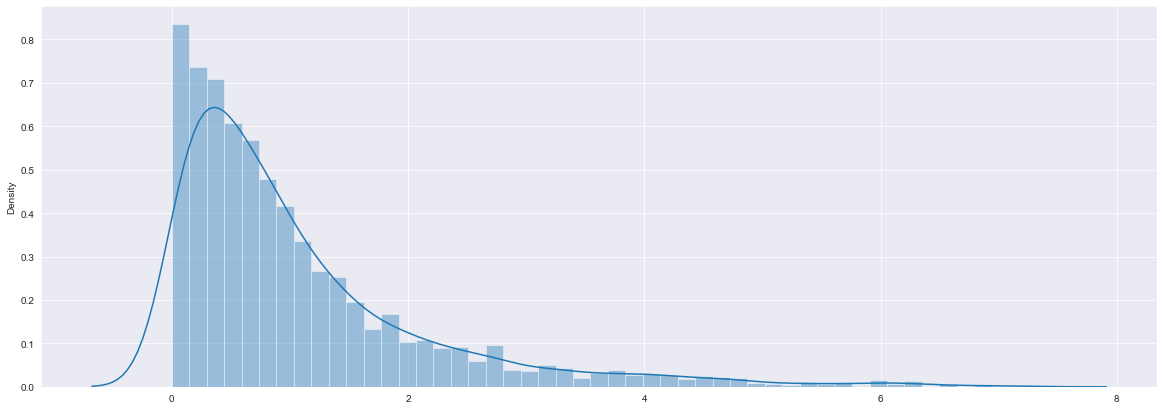

In [268]:
sns.distplot(abs(df.y_true - df.y_pred))
plt.show()

In [269]:
indexlist = df[abs(df.y_true - df.y_pred) > float(3)].index
train_df_copy_n.iloc[indexlist].is_warehouse_closed.value_counts()

0    215
Name: is_warehouse_closed, dtype: int64

In [270]:
df.loc[indexlist].head()

,index,y_true,y_pred
4,14337,5.3,0.803712
8,11784,9.3,3.846448
19,12713,7.5,4.104905
20,15352,7.5,1.576080
23,12895,3.5,6.523522


# Test Data

In [228]:
Filepath = r'D:\Samarjit\Hackerearth\Tredence\Data\cc2dca92b57d11ec\dataset\test.csv'
test_df = pd.read_csv(Filepath,parse_dates=['date'])
test_df.head()

,ID,date,warehouse_ID,Latitude,Longitude,Product_Type,year,month,is_weekend,is_warehouse_closed
0,0x31fc,2021-05-01,WH_0x3e9,41.681471,NaN,Type_A,2021,May,NaN,No
1,0x31fd,2021-05-01,WH_0x3e9,41.681471,NaN,Type_B,2021,May,Yes,No
2,0x3ed2,2021-05-01,WH_0x3ea,38.749077,-105.183060,Type_A,2021,May,Yes,No
3,0x3ed3,2021-05-01,WH_0x3ea,38.749077,-105.183060,Type_B,2021,May,Yes,No
4,0x4a3a,2021-05-01,WH_0x3eb,35.678970,-109.067413,Type_A,2021,May,Yes,Yes


In [229]:
test_df.shape

(4900, 10)

# Feature Transformation

In [230]:
test_df['weekday']=test_df.date.dt.weekday

In [231]:
test_df['is_Sunday']=test_df['weekday'].apply(lambda x:'Yes' if x==6 else 'No')

In [232]:
test_df.is_weekend.fillna(test_df.date.dt.weekday,inplace=True)
test_df.is_weekend = test_df.is_weekend.apply(lambda x: 'Yes' if x not in ['Yes','No'] and x in ['5','6'] else ('No' if x not in ['Yes','No'] else x))

In [233]:
test_df.is_Sunday.value_counts()

No     4200
Yes     700
Name: is_Sunday, dtype: int64

In [234]:
test_df.isnull().sum()

ID                       0
date                     0
warehouse_ID             0
Latitude                98
Longitude              122
Product_Type             0
year                     0
month                    0
is_weekend               0
is_warehouse_closed     49
weekday                  0
is_Sunday                0
dtype: int64

In [235]:
print('{} % is probable for warehouse to be closed on weekend for weekly dispatch.'.format(round(((test_df[(test_df.is_weekend == 'Yes') & \
                                         (test_df.is_warehouse_closed == 'Yes')].shape[0]/test_df.shape[0])*100),4)))
print('{} % is probable for warehouse to be opened on weekend for weekly dispatch.'.format(round(((test_df[(test_df.is_weekend == 'Yes') & \
                                         (test_df.is_warehouse_closed == 'No')].shape[0]/test_df.shape[0])*100),4)))

7.898 % is probable for warehouse to be closed on weekend for weekly dispatch.
19.6531 % is probable for warehouse to be opened on weekend for weekly dispatch.


In [236]:
print('{} % is probable for warehouse to be closed on weekdays for weekly dispatch.'.format(round(((test_df[(test_df.is_weekend == 'No') & \
                                         (test_df.is_warehouse_closed == 'Yes')].shape[0]/test_df.shape[0])*100),4)))
print('{} % is probable for warehouse to be opened on weekdays for weekly dispatch.'.format(round(((test_df[(test_df.is_weekend == 'No') & \
                                         (test_df.is_warehouse_closed == 'No')].shape[0]/test_df.shape[0])*100),4)))

15.7551 % is probable for warehouse to be closed on weekdays for weekly dispatch.
55.6939 % is probable for warehouse to be opened on weekdays for weekly dispatch.


### verify the warehouse_id

In [237]:
sorted(test_df.warehouse_ID.unique()) == sorted(train_df.warehouse_ID.unique())

True

### Missing Value Imputation

In [238]:
test_df.is_warehouse_closed.fillna('No',inplace=True)

In [239]:
def imputemissing(df,group_df,driver,sel_cols):
  for cols in sel_cols:
    for index,row in df[df[cols].isnull() == True].iterrows():
      value = group_df[group_df[driver] == row[driver]][cols].values[0]
      df[cols].loc[index] = value

  return df

sel_cols = ['Latitude','Longitude']
group_lat_df = pd.DataFrame(test_df.groupby(by='warehouse_ID')[sel_cols[0]].max())
group_lat_df.reset_index(inplace=True)
group_long_df = pd.DataFrame(test_df.groupby(by='warehouse_ID')[sel_cols[1]].max())
group_long_df.reset_index(inplace=True)
group_df = pd.merge(group_lat_df,group_long_df,on = 'warehouse_ID',how = 'inner')
group_df

test_df = imputemissing(test_df,group_df,'warehouse_ID',sel_cols)
test_df[sel_cols].isnull().sum()

Latitude     0
Longitude    0
dtype: int64

In [240]:
test_df[test_df['warehouse_ID'].isin(test_df['warehouse_ID'].unique())]['Latitude'].unique()

array([41.681471, 38.749077, 35.67897 , 34.361664, 25.750156, 30.189375,
       41.611603, 37.915825, 48.692551, 61.600803])

In [241]:
test_df[test_df['warehouse_ID'].isin(test_df['warehouse_ID'].unique())]['Longitude'].unique()

array([ -72.794746, -105.18306 , -109.067413,  -86.305595,  -80.27964 ,
        -82.648254,  -87.551186,  -89.829262, -116.319862, -149.125259])

In [242]:
def convertmonth(x):
  month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December']
  monthnum = range(1,13,1)
  monthdict = dict()
  for v1,v2 in zip(month,monthnum):
    monthdict[v1] = v2
  
  return monthdict[x]

In [243]:
def encodeWid(x):
  warehouse_list = ['WH_0x3e9', 'WH_0x3ea', 'WH_0x3eb', 'WH_0x3ec', 'WH_0x3ed',
       'WH_0x3ee', 'WH_0x3ef', 'WH_0x3f1', 'WH_0x3f0', 'WH_0x3f2']

  numbers = range(1,11,1)
  warehouse_dict = dict()
  for v1,v2 in zip(warehouse_list,numbers):
    warehouse_dict[v1] = v2
  
  return warehouse_dict[x]

In [244]:
test_df.Product_Type = test_df.Product_Type.apply(lambda x: 0 if x == 'Type_A' else 1)
test_df.is_weekend = test_df.is_weekend.apply(lambda x: 1 if x == 'Yes' else 0)
test_df.is_warehouse_closed = test_df.is_warehouse_closed.apply(lambda x: 1 if x == 'Yes' else 0)
#test_df.month = test_df.month.apply(lambda x: convertmonth(x))
test_df.warehouse_ID = test_df.warehouse_ID.apply(lambda x: encodeWid(x))

In [245]:
def cordinate1(df):
  df['x-co'] = pd.Series([np.cos(lat) * np.cos(lon) for lat,lon in df[['Latitude','Longitude']].values])
  df['y-co'] = pd.Series([np.cos(lat) * np.sin(lon) for lat,lon in df[['Latitude','Longitude']].values])
  df['z-co'] = pd.Series([np.sin(lat) for lat in df['Latitude'].values])
  return df

In [246]:
test_df = cordinate1(test_df)

In [247]:
test_df.drop(columns = ['Latitude','Longitude'],inplace=True)

In [248]:
test_df.isnull().sum()

ID                     0
date                   0
warehouse_ID           0
Product_Type           0
year                   0
month                  0
is_weekend             0
is_warehouse_closed    0
weekday                0
is_Sunday              0
x-co                   0
y-co                   0
z-co                   0
dtype: int64

In [249]:
test_df.head()

,ID,date,warehouse_ID,Product_Type,year,month,is_weekend,is_warehouse_closed,weekday,is_Sunday,x-co,y-co,z-co
0,0x31fc,2021-05-01,1,0,2021,May,0,0,5,No,0.572644,-0.341794,-0.745155
1,0x31fd,2021-05-01,1,1,2021,May,1,0,5,No,0.572644,-0.341794,-0.745155
2,0x3ed2,2021-05-01,2,0,2021,May,1,0,5,No,-0.029984,0.496697,0.867406
3,0x3ed3,2021-05-01,2,1,2021,May,1,0,5,No,-0.029984,0.496697,0.867406
4,0x4a3a,2021-05-01,3,0,2021,May,1,1,5,No,0.273965,0.337084,-0.900732


In [250]:
test_df[test_df.is_warehouse_closed==1].shape

(1159, 13)

Check for any additional Warehouse introduced in 2021

In [251]:
len(test_df.warehouse_ID.unique())

10

In [252]:
test_df_copy = test_df.copy()

In [253]:
test_df_copy['day'] = test_df_copy.date.dt.day
test_df_copy.is_Sunday = test_df_copy.is_Sunday.apply(lambda x: 1 if x == 'Yes' else 0)

In [254]:
test_df_copy = pd.get_dummies(test_df_copy, \
                columns=['warehouse_ID', 'is_weekend','weekday','day'])
test_df_copy.head()

,ID,date,Product_Type,year,month,is_warehouse_closed,is_Sunday,x-co,y-co,z-co,warehouse_ID_1,warehouse_ID_2,warehouse_ID_3,warehouse_ID_4,warehouse_ID_5,warehouse_ID_6,warehouse_ID_7,warehouse_ID_8,warehouse_ID_9,warehouse_ID_10,is_weekend_0,is_weekend_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,0x31fc,2021-05-01,0,2021,May,0,0,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0x31fd,2021-05-01,1,2021,May,0,0,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0x3ed2,2021-05-01,0,2021,May,0,0,-0.029984,0.496697,0.867406,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0x3ed3,2021-05-01,1,2021,May,0,0,-0.029984,0.496697,0.867406,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0x4a3a,2021-05-01,0,2021,May,1,0,0.273965,0.337084,-0.900732,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [255]:
test_df_copy.shape

(4900, 60)

In [256]:
Idvalues = test_df_copy.ID

### Encoding Year & Month

In [257]:
test_df_copy['year'] = test_df_copy['year'].apply(lambda x: str(x))

In [258]:
test_df_copy.head()

,ID,date,Product_Type,year,month,is_warehouse_closed,is_Sunday,x-co,y-co,z-co,warehouse_ID_1,warehouse_ID_2,warehouse_ID_3,warehouse_ID_4,warehouse_ID_5,warehouse_ID_6,warehouse_ID_7,warehouse_ID_8,warehouse_ID_9,warehouse_ID_10,is_weekend_0,is_weekend_1,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,0x31fc,2021-05-01,0,2021,May,0,0,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0x31fd,2021-05-01,1,2021,May,0,0,0.572644,-0.341794,-0.745155,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0x3ed2,2021-05-01,0,2021,May,0,0,-0.029984,0.496697,0.867406,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0x3ed3,2021-05-01,1,2021,May,0,0,-0.029984,0.496697,0.867406,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0x4a3a,2021-05-01,0,2021,May,1,0,0.273965,0.337084,-0.900732,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [259]:
X_test_year_bow = CountVectorizer1.transform(test_df_copy.year.values)
X_test_month_bow = CountVectorizer2.transform(test_df_copy.month.values)

print(X_test_year_bow.shape)
print(X_test_month_bow.shape)

(4900, 5)
(4900, 12)


In [260]:
sel_cols = [col for col in test_df_copy.columns if col not in ['ID','date','year', 'month']]

X_test = hstack((test_df_copy[sel_cols],X_test_year_bow,X_test_month_bow)).tocsr()

print(X_test.shape)

(4900, 73)


# Model Evaluation

In [261]:
def FinalEnsembleModelExMethod(df,data):
    filapth = r'D:\\Samarjit\\Hackerearth\\Tredence\\'
    modellistnames = ['model_2.h5','model_1.h5']
    model = list()
    for idx,modelname in enumerate(modellistnames):
        if modelname.endswith('h5') == True:
            modelfile = filapth + modelname
            model.append(tf.keras.models.load_model(modelfile))
            print('Model-{} is Loaded...'.format(idx+1))
        else:
            modelfile = filapth + modelname
            with open(modelfile,'rb') as f:
                model.append(pickle.load(f))
                print('Model-{} is Loaded...'.format(idx+1))
        
    y_pred_data = list()
    for idx in range(df.shape[0]):
        temp = list()
        temp.append(Idvalues[idx])
        for index,m in enumerate(model):
            if index == 0:
                if df['is_warehouse_closed'].iloc[idx] == 1:
                    temp.append(float(0))
                else:
                    temp.append(m.predict(data[idx]).flatten()[0])
            elif index == 1:
                if df['is_Sunday'].iloc[idx] == 'No':
                    temp.append(np.nan)
                else:
                    temp.append(m.predict(data[idx]).flatten()[0])
            
        y_pred_data.append(temp)
    
    #print(y_pred_data)
    df = pd.DataFrame(y_pred_data,columns = ['ID','daily_dispatch_count','weekly_dispatch_count'])
    #print(df.shape)
    
    if df.daily_dispatch_count.shape[0] == df.weekly_dispatch_count.shape[0]:
        print('Model Evaluation Completed..')
        return df
    else:
        print('error in model-Evaluation..')

In [262]:
df = FinalEnsembleModelExMethod(test_df,X_test)

Model-1 is Loaded...
Model-2 is Loaded...
Model Evaluation Completed..


In [263]:
df.head()

,ID,daily_dispatch_count,weekly_dispatch_count
0,0x31fc,2.797214,NaN
1,0x31fd,0.593970,NaN
2,0x3ed2,3.595589,NaN
3,0x3ed3,1.189333,NaN
4,0x4a3a,0.000000,NaN


In [264]:
df.shape

(4900, 3)

In [265]:
test_df = pd.merge(test_df,df,on = 'ID',how = 'outer')
#test_df.reset_index(inplace=True)
test_df.head()

,ID,date,warehouse_ID,Product_Type,year,month,is_weekend,is_warehouse_closed,weekday,is_Sunday,x-co,y-co,z-co,daily_dispatch_count,weekly_dispatch_count
0,0x31fc,2021-05-01,1,0,2021,May,0,0,5,No,0.572644,-0.341794,-0.745155,2.797214,NaN
1,0x31fd,2021-05-01,1,1,2021,May,1,0,5,No,0.572644,-0.341794,-0.745155,0.593970,NaN
2,0x3ed2,2021-05-01,2,0,2021,May,1,0,5,No,-0.029984,0.496697,0.867406,3.595589,NaN
3,0x3ed3,2021-05-01,2,1,2021,May,1,0,5,No,-0.029984,0.496697,0.867406,1.189333,NaN
4,0x4a3a,2021-05-01,3,0,2021,May,1,1,5,No,0.273965,0.337084,-0.900732,0.000000,NaN


In [266]:
test_df.shape

(4900, 15)

In [267]:
test_df[['daily_dispatch_count','weekly_dispatch_count']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4900 entries, 0 to 4899
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   daily_dispatch_count   4900 non-null   float64
 1   weekly_dispatch_count  700 non-null    float64
dtypes: float64(2)
memory usage: 114.8 KB


# submission file

In [268]:
Filepath = r'D:\Samarjit\Hackerearth\Tredence\Data\cc2dca92b57d11ec\dataset\submission_weekly.csv'
submission_weekly_df = pd.read_csv(Filepath)
submission_weekly_df.head()

,ID,weekly_dispatch_count
0,0x31fe,NaN
1,0x31ff,NaN
2,0x3ed4,NaN
3,0x3ed5,NaN
4,0x4a3c,NaN


In [269]:
sample_submission_df = pd.merge(test_df,submission_weekly_df['ID'],on = 'ID',how='inner')

In [270]:
sample_submission_df.head()

,ID,date,warehouse_ID,Product_Type,year,month,is_weekend,is_warehouse_closed,weekday,is_Sunday,x-co,y-co,z-co,daily_dispatch_count,weekly_dispatch_count
0,0x31fe,2021-05-02,1,0,2021,May,1,0,6,Yes,0.572644,-0.341794,-0.745155,2.813149,22.504169
1,0x31ff,2021-05-02,1,1,2021,May,1,0,6,Yes,0.572644,-0.341794,-0.745155,1.217361,8.822299
2,0x3ed4,2021-05-02,2,0,2021,May,1,0,6,Yes,-0.029984,0.496697,0.867406,3.885145,38.814594
3,0x3ed5,2021-05-02,2,1,2021,May,1,0,6,Yes,-0.029984,0.496697,0.867406,1.759961,13.730885
4,0x4a3c,2021-05-02,3,0,2021,May,1,0,6,Yes,0.273965,0.337084,-0.900732,3.185347,33.470367


In [271]:
sample_submission_df = sample_submission_df[['ID','weekly_dispatch_count']]

In [278]:
sample_submission_df.weekly_dispatch_count = sample_submission_df.weekly_dispatch_count.apply(lambda x: round(x,1))

In [279]:
sample_submission_df.head()

,ID,weekly_dispatch_count
0,0x31fe,22.5
1,0x31ff,8.8
2,0x3ed4,38.8
3,0x3ed5,13.7
4,0x4a3c,33.5


In [280]:
sample_submission_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     700 non-null    object 
 1   weekly_dispatch_count  700 non-null    float64
dtypes: float64(1), object(1)
memory usage: 16.4+ KB


In [281]:
sample_submission_df.shape

(700, 2)

In [282]:
sample_submission_df.to_csv('D:\Samarjit\Hackerearth\Tredence\Data\cc2dca92b57d11ec\dataset\submission_weekly_final.csv',\
                            index = False)